# 📚 Import Necessary Libraries

In this section, we import all the essential libraries for our image classification project 🧠. These include tools for:

- Image handling 🖼️
- Load the create Model 🤖

In [1]:
# For loading
import cv2

# Import MediaPipe for real-time face, hand, and pose detection
import mediapipe as mp

# To load previously saved model
from tensorflow.keras.models import load_model   

# 📊 Import the required library
import matplotlib.pyplot as plt

# 💾 Load the Trained Model

I already save the trained model to a `.keras` file for future use.  
Now, I can load it back using `load_model()` to make predictions or continue training without retraining from scratch 💡🔁.

In [2]:
model = load_model('face_mask_detector_model.keras')  # works perfectly

# 🕵️‍♂️ Face Mask Detection Function

This function takes an image as input, reshapes it to the required format, and normalizes pixel values.  
It then uses the trained model to predict whether the person is wearing a mask (`0`) or not (`1`) 😷🚫.

In [3]:
def detect_face_mask(img):
    # Reshape and normalize the input image
    img = img.reshape(1, 224, 224, 3) / 255.0
    
    # Predict using the trained model
    y_pred = model.predict(img)
    
    # Convert the prediction to binary label (0 or 1)
    label = int(y_pred[0][0] > 0.5)
    
    return label

# 🖍️ Draw Label on Image

This function displays a label with a colored background on an image using OpenCV.  
It draws a filled rectangle behind the text for better visibility and overlays the label text at the specified position ✍️🎨.

In [4]:
def draw_label(img, text, pos, bg_color):
    # Get the size of the text to be displayed
    text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1, cv2.FILLED)

    # Calculate coordinates for the background rectangle
    end_x = pos[0] + text_size[0][0] + 2
    end_y = pos[1] + text_size[0][1] - 2

    # Draw the filled rectangle as background
    cv2.rectangle(img, pos, (end_x, end_y), bg_color, cv2.FILLED)

    # Put the text label on top of the rectangle
    cv2.putText(img, text, pos, cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 1, cv2.LINE_AA)

# 👤 Face Detection Using Mediapipe and Haar Cascades

This function detects faces in an image using either **Mediapipe** or **Haar cascades**:

- If `use_mediapipe=True`, it tries to use **Mediapipe Face Detection** for better accuracy 🧠🔍.
- If Mediapipe is unavailable or not used, it falls back to **Haar cascades** to detect either **frontal** or **profile** faces 📷.

It returns a list of bounding boxes for the detected faces.

In [5]:
# Load Haar cascade classifiers for detecting frontal and profile faces
frontal_haar = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
profile_haar = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')

# Define a function to detect faces using either Mediapipe or Haar cascades
def detect_faces_multi(img, use_mediapipe=False):
    faces = []

    # Try using Mediapipe if enabled and available
    if use_mediapipe:
        try:
            import mediapipe as mp
            mp_face = mp.solutions.face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = mp_face.process(img_rgb)

            if results.detections:
                for det in results.detections:
                    bbox = det.location_data.relative_bounding_box
                    h, w, _ = img.shape
                    x = int(bbox.xmin * w)
                    y = int(bbox.ymin * h)
                    width = int(bbox.width * w)
                    height = int(bbox.height * h)
                    faces.append((x, y, width, height))
                return faces
        except ImportError:
            print("Mediapipe not installed, skipping...")

    # Fallback to Haar frontal face detection
    faces = frontal_haar.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)
    if len(faces) > 0:
        return faces

    # If no frontal face is found, use profile face detection
    faces = profile_haar.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)
    return faces

# 🧪 Test on a Sample Image

We read a sample image from the `sample/` directory and resize it to 224x224 pixels.  
Then, we use the `detect_face_mask()` function to predict whether the person in the image is wearing a mask or not 😷🤖.

In [6]:
def show_and_predict(image_path):

    # Read and resize image
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (224, 224))
    
    # Convert BGR to RGB for correct display
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.imshow(img_rgb)
    plt.title('Sample Image')
    plt.axis('off')
    plt.show()
    
    # Run detection
    prediction = detect_face_mask(img_resized)
    if prediction == 0:
        print(f"Prediction for '{image_path}': With Mask 😷")
    else:
        print(f"Prediction for '{image_path}': Without Mask ❌")

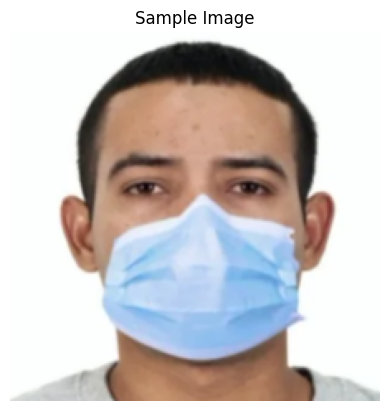

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
Prediction for 'sample/with_mask_004.png': With Mask 😷


In [7]:
show_and_predict('sample/with_mask_004.png')

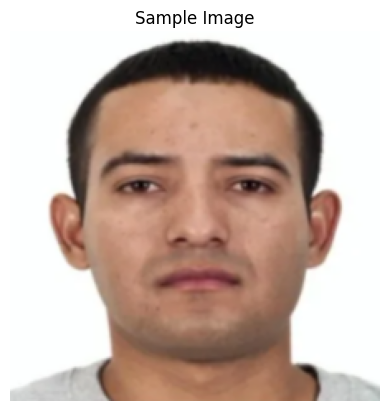

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Prediction for 'sample/without_mask_004.png': Without Mask ❌


In [8]:
show_and_predict('sample/without_mask_004.png')

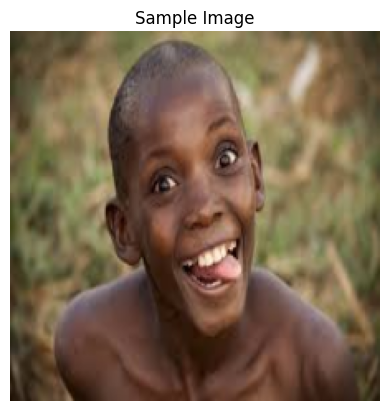

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Prediction for 'sample/without_maks_001.jpg': Without Mask ❌


In [9]:
show_and_predict('sample/without_maks_001.jpg')

# 🎥🧠 Access Webcam Feed and Real-Time Face Mask Detection

We use `cv2.VideoCapture(0)` to access the default webcam.  
This allows us to capture real-time video frames for mask detection 📸🧠.

The live video is processed frame-by-frame to detect faces and predict mask usage:

- Each frame is resized and passed to the trained model to check for mask presence 😷❌
- Faces are detected using Mediapipe (or Haar cascades as a fallback) 🧑‍💻📷
- Bounding boxes are drawn around detected faces and a label ("Mask" or "No Mask") is displayed based on the prediction
- Press **'x'** to stop the detection loop and close the webcam window 📸🛑

In [10]:
cap = cv2.VideoCapture(0)   # Access Webcam Feed
while True:
    # Capture frame from webcam
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame to match model input size
    img = cv2.resize(frame, (224, 224))

    # Predict mask presence
    y_pred = detect_face_mask(img)

    # Convert frame to grayscale for Haar detection (not used here but kept for compatibility)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces using Mediapipe (falls back to Haar if needed)
    coods = detect_faces_multi(frame, use_mediapipe=True)

    # Draw bounding boxes around detected faces
    for x, y, w, h in coods:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Draw label based on prediction
    if y_pred == 0:
        draw_label(frame, "Mask", (50, 50), (0, 255, 0))     # Green for Mask
    else:
        draw_label(frame, "No Mask", (50, 50), (0, 0, 255))  # Red for No Mask

    # Display the frame
    cv2.imshow("window", frame)

    # Exit loop when 'x' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('x'):
        break

# Release resources
cap.release()

cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
